In [1]:
# Section Project:
# For the final project for this section, you're going to train a DP model using this PATE method on the MNIST dataset, provided below.

import torch
from torch import nn
import numpy as np
import helper
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

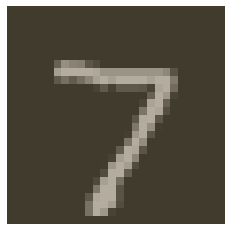

In [2]:
# *********** Load the data **********

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
mnist_testset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(mnist_trainset,batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset,batch_size=1)

# *********** Check the data **********
img, label = next(iter(testloader))
helper.imshow(img[0])


In [3]:
# *********** Part from the exercise **********
# TODO how can I use it?
train_data = mnist_trainset.data
train_targets = mnist_trainset.targets

print(train_data.shape)

test_data = mnist_testset.data
test_targets = mnist_testset.targets

print(test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [4]:
# *********** Prepare input for PATH analysis **********
num_teachers = 100
num_examples = len(mnist_testset)
num_labels = 10

lengths  = [len(mnist_trainset)//num_teachers]*num_teachers
trainsets = torch.utils.data.random_split(mnist_trainset, lengths)

print('num_examples:', num_examples)
len(lengths)

num_examples: 10000


100

In [5]:
# *********** Create the model **********
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('fc1',  nn.Linear(784, 512)),
    ('relu', nn.ReLU()),
    ('drop', nn.Dropout(p=0.2)),
    ('fc2',  nn.Linear(512, 128)),
    ('relu', nn.ReLU()),
    ('fc3',  nn.Linear(128, 10)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [6]:
# *********** Train the model **********
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
   
model.to(device)

epochs = 5
step = 0

preds = []

for i in range(num_teachers):
    print('Trainset:', i+1)
    pred = []

    for e in range(epochs):
        #print('Epoch:', e+1)
        running_loss = 0
        trainloader = torch.utils.data.DataLoader(trainsets[i], batch_size=64, shuffle=True)
        
        for imgs, labels in trainloader:
            step += 1
            imgs = imgs.view(imgs.shape[0], -1)
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            logps = model(imgs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            test_loss = 0
            accuracy  = 0

            for imgs, labels in testloader:
                imgs = imgs.view(imgs.shape[0], -1)
                imgs, labels = imgs.to(device), labels.to(device)

                logps = model(imgs)
                loss = criterion(logps, labels)
                test_loss += loss.item()

                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

                pred.append(top_class.cpu().flatten())
        model.train()

        print( 'Training loss:', running_loss/(epochs*num_teachers) )
        print( 'Test loss:', test_loss/len(testloader) )
        print( 'Accuracy:', accuracy/len(testloader) )

    preds.append( np.array(pred) )
    print('Pred shape:', np.array(pred).shape)
preds = np.array(preds)
print('Preds shape:', preds.shape)

Trainset: 1
Training loss: 0.009065991640090943
Test loss: 0.5354745752453804
Accuracy: 0.8405
Pred shape: (10000,)
Trainset: 2
Training loss: 0.004999106422066689
Test loss: 0.4560947495818138
Accuracy: 0.8639
Pred shape: (10000,)
Trainset: 3
Training loss: 0.004196941927075386
Test loss: 0.37976614516973495
Accuracy: 0.8843
Pred shape: (10000,)
Trainset: 4
Training loss: 0.004449522078037262
Test loss: 0.35352672218084336
Accuracy: 0.8915
Pred shape: (10000,)
Trainset: 5
Training loss: 0.004364485293626786
Test loss: 0.3357378056645393
Accuracy: 0.8957
Pred shape: (10000,)
Trainset: 6
Training loss: 0.004103996932506561
Test loss: 0.3688022726893425
Accuracy: 0.884
Pred shape: (10000,)
Trainset: 7
Training loss: 0.003914005383849144
Test loss: 0.26416834944486617
Accuracy: 0.921
Pred shape: (10000,)
Trainset: 8
Training loss: 0.002401392966508865
Test loss: 0.29502897292375563
Accuracy: 0.9124
Pred shape: (10000,)
Trainset: 9
Training loss: 0.003326192259788513
Test loss: 0.299552948

Training loss: 0.0011947111040353775
Test loss: 0.16877378964424133
Accuracy: 0.9513
Pred shape: (10000,)
Trainset: 72
Training loss: 0.0009462346956133843
Test loss: 0.16878813257217407
Accuracy: 0.9533
Pred shape: (10000,)
Trainset: 73
Training loss: 0.0012289856374263764
Test loss: 0.16307987217903136
Accuracy: 0.958
Pred shape: (10000,)
Trainset: 74
Training loss: 0.001612268254160881
Test loss: 0.17386366680860518
Accuracy: 0.9536
Pred shape: (10000,)
Trainset: 75
Training loss: 0.002413927190005779
Test loss: 0.2039376142859459
Accuracy: 0.9428
Pred shape: (10000,)
Trainset: 76
Training loss: 0.0015791537016630172
Test loss: 0.1477013156056404
Accuracy: 0.9582
Pred shape: (10000,)
Trainset: 77
Training loss: 0.000991596095263958
Test loss: 0.15542731709480287
Accuracy: 0.9577
Pred shape: (10000,)
Trainset: 78
Training loss: 0.0007409594282507897
Test loss: 0.16518702783584593
Accuracy: 0.9555
Pred shape: (10000,)
Trainset: 79
Training loss: 0.0015107122361660004
Test loss: 0.1656

In [7]:
# *********** NEW Labels **********
from syft.frameworks.torch.differential_privacy import pate

new_labels = []
pred = preds.transpose()

for image in pred:
    label_counts = np.bincount(image, minlength=num_labels)
    
    epsilon = 0.1
    beta = 1/epsilon
    
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)
        
    new_label = np.argmax(label_counts)  
    new_labels.append(new_label)

#new_labels       

In [15]:
# *********** PATE analysis **********
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=pred.transpose(),
                                                   indices=np.array(new_labels),
                                                   noise_eps=0.1,
                                                   delta=1e-5)

print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 411.5129254649703
Data Dependent Epsilon: 55.18300925477453
